In [1]:
import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import math

import os
import sys
sys.path.append('../utils')
sys.path.append('..')

from utils import read_all_datasets, prepare_data


In [2]:
dataset_name = 'LargeKitchenAppliances'
# dataset_name = 'MoteStrain'

datasets_dict = read_all_datasets([dataset_name])

trainloader, valloader, input_shape, nb_classes = prepare_data(datasets_dict, dataset_name)


batch_size is  16


### Classifier Model - Convolution

In [15]:
from torch import nn

class FCN(nn.Module):

    def __init__(self, input_shape, nb_classes, filter_count):
        super(FCN, self).__init__()
        self.nb_classes = nb_classes
        self.filter_count = filter_count

        self.max_pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.filter_count, kernel_size=8, stride=1, padding='same', bias=False)
        self.bn1 = nn.BatchNorm1d(self.filter_count,)
    
        # self.conv2 = nn.Conv1d(in_channels=self.filter_count, out_channels=self.filter_count*2, kernel_size=5, stride=1, padding='same', bias=False)
        # self.bn2 = nn.BatchNorm1d(self.filter_count*2,)
            
        # self.conv3 = nn.Conv1d(in_channels=self.filter_count*2, out_channels=self.filter_count, kernel_size=3, stride=1, padding='same', bias=False)
        # self.bn3 = nn.BatchNorm1d(self.filter_count,)

        self.relu = nn.ReLU()

        self.avgpool1 = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(self.filter_count, self.nb_classes)

    def forward(self, x):
        # First convolutional block
        x = self.max_pool(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # # Second convolutional block
        # x = self.conv2(x)
        # x = self.bn2(x)
        # x = self.relu(x)
        
        # # # Third convolutional block
        # x = self.conv3(x)
        # x = self.bn3(x)
        # x = self.relu(x)

        x = self.avgpool1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x

### Train the model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
def test(model):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        for b_idx, (x, y) in enumerate(valloader):
            (x, y) = x.to(device), y.to(device)
            pred = model(x.float())

            loss = lossFn(pred, y)
            test_loss += loss.item()

            total += y.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)' % (test_loss / (b_idx + 1), 100. * correct / total, correct, total))
        return test_loss / (b_idx + 1), 100. * correct / total

In [18]:
# pool of size=3, stride=2
m = nn.MaxPool1d(kernel_size=2, stride=2,)
input = torch.randn(20, 16, 50)
output = m(input)

In [19]:
output.shape

torch.Size([20, 16, 25])

In [ ]:
import torch.optim as optim
import torch.backends.cudnn as cudnn

seed=42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False

model = FCN((360, 1), 3, 128)
lossFn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,)
EPOCHS = 2000

model.to(device)

train_losses, test_losses, test_accs = [], [], []

for e in range(0, EPOCHS):
    print('Epoch: ', e)
    model.train()

    # initlaize total training loss
    totalTainLoss = 0

    # initialize number of correct predictions in the training
    trainCorrect = 0

    for (x, y) in trainloader:
        # send the input to the device
        x, y = x.to(device), y.to(device)
        
        # perform a forward pass and calculate the training loss
        pred = model(x.float())
        loss = lossFn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()


    print('Train loss: ', totalTainLoss.item())
    train_losses.append(totalTainLoss.item())
    test_loss, test_acc = test(model)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print('\n\n')


In [ ]:
import torch.optim as optim

model = FCN((720, 1), 3, 128)
lossFn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), )
base_optimizer = torch.optim.Adam
optimizer = SAM(model.parameters(), base_optimizer, )

# optimizer = optim.Adam(model.parameters(), lr=0.001,)
EPOCHS = 2000

model.to(device)

train_losses, test_losses, test_accs = [], [], []

for e in range(0, EPOCHS):
    print('Epoch: ', e)
    # model.train()

    # # initlaize total training loss
    # totalTainLoss = 0

    # # initialize number of correct predictions in the training
    # trainCorrect = 0

    # for (x, y) in trainloader:
    #     # send the input to the device
    #     x, y = x.to(device), y.to(device)
        
    #     # perform a forward pass and calculate the training loss
    #     pred = model(x.float())
    #     loss = lossFn(pred, y)

    #     optimizer.zero_grad()
    #     loss.backward()
    #     optimizer.step()

    #     totalTainLoss += loss
    #     trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    

    model.train()

    # initlaize total training loss
    totalTainLoss = 0

    # initialize number of correct predictions in the training
    trainCorrect = 0

    for (x, y) in trainloader:
        optimizer.zero_grad()
        # send the input to the device
        x, y = x.to(device), y.to(device)
        # perform a forward pass and calculate the training loss
        pred = model(x.float())
        loss = lossFn(pred, y)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        lossFn(model(x.float()), y).backward()  
        optimizer.second_step(zero_grad=True)

        totalTainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # break
    print('Train loss: ', totalTainLoss.item())
    train_losses.append(totalTainLoss.item())
    test_loss, test_acc = test(model)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print('\n')

In [138]:
import torch
import torch.nn as nn
import math

class Padding(nn.Module):

    def __init__(self, patch_size):
        super(Padding, self).__init__()
        self.patch_size = patch_size

    def forward(self, x):
        B, D, L= x.size()
        # print('x shape: ', x.shape)
        if L % self.patch_size != 0:
            padd_size = self.patch_size - L % self.patch_size
            # print('padd_size: ', padd_size)
            num_patches = math.ceil(L / self.patch_size)
            # print('num_patches: ', num_patches)
            last_elements = x[:, :, -1:]
            # print('last_elements: ', last_elements.shape)
            num_missing_values = self.patch_size - (L % self.patch_size)
            # print('num_missing_values: ', num_missing_values)
            if num_missing_values > 0:
                padding = last_elements.repeat(1, 1, num_missing_values)
                # print('padding shape: ', padding.shape)
                x = torch.cat([x, padding], dim=2)
                # print('x shape: ', x.shape)
            # print('final shape: ', x.shape)

            x = x.view(B, D, -1, self.patch_size)
        else:
            # print('B: ', B)
            # print('D: ', D)

            x = x.view(B, D, -1, self.patch_size)

        # print('before permutation: ', x.shape)
        return  x.permute(0, 1, 3, 2)

In [87]:
arr = np.arange(1, 101).reshape(1, 1, 20, 5)
arr.shape
arr = np.transpose(arr, axes=(0, 1, 3, 2))
arr


array([[[[  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,
           61,  66,  71,  76,  81,  86,  91,  96],
         [  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,
           62,  67,  72,  77,  82,  87,  92,  97],
         [  3,   8,  13,  18,  23,  28,  33,  38,  43,  48,  53,  58,
           63,  68,  73,  78,  83,  88,  93,  98],
         [  4,   9,  14,  19,  24,  29,  34,  39,  44,  49,  54,  59,
           64,  69,  74,  79,  84,  89,  94,  99],
         [  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
           65,  70,  75,  80,  85,  90,  95, 100]]]])

In [109]:
emb_size = 16
embed_layer = nn.Sequential(nn.Conv1d(1, emb_size, kernel_size=8, padding='same'),
                                         nn.BatchNorm1d(emb_size),
                                         nn.GELU())
embed_layer2 = nn.Sequential(nn.Conv2d(1, emb_size, kernel_size=[8, 1], padding='valid'),
                                    nn.BatchNorm2d(emb_size),
                                    nn.GELU())

for (x, y) in trainloader:
    print('input shape: ', x.shape)                                        
    print('target shape: ', y.shape)                                        
    patching_layer = Padding(patch_size=8)
    x = patching_layer(x)
    print('Input shape after patching: ', x.shape)
    print(type(x))
    x = embed_layer2(x.float())
    print('Input shape after embedding layer: ', x.shape)
    break

input shape:  torch.Size([16, 1, 720])
target shape:  torch.Size([16])
x shape:  torch.Size([16, 1, 720])
B:  16
D:  1
before permutation:  torch.Size([16, 1, 90, 8])
Input shape after patching:  torch.Size([16, 1, 8, 90])
<class 'torch.Tensor'>
Input shape after embedding layer:  torch.Size([16, 16, 1, 90])


In [104]:
x[14][0][2]

tensor([ 0.5772, -1.5762, -1.5762,  0.5772,  0.5772,  0.5772,  0.5772, -1.5762,
        -1.5762,  0.5772,  0.5772,  0.5772,  0.5772, -1.5762, -1.5762,  0.5772,
         0.5772,  0.5772,  0.5772,  0.5772, -1.5762, -1.5762,  0.5772,  0.5772,
         0.5772,  0.5772, -1.5762,  0.5772,  0.5772,  0.5772, -1.5762,  0.5772,
         0.5772,  0.5772,  0.5772, -1.5762, -1.5762,  0.5772,  0.5772,  0.5772,
        -1.5762,  0.5772,  0.5772,  0.5772, -1.5762,  0.5772,  0.5772,  0.5772,
        -1.5762,  0.5772,  0.5772,  0.5772,  0.5772, -1.5762,  0.5772,  0.5772,
         0.5772, -1.5762,  0.5772,  0.5772,  0.5772,  0.5772, -1.5762,  0.5772,
         0.5772, -1.5762,  0.5772,  0.5772,  0.5772, -1.5762,  0.5772,  0.5772,
         0.5772, -1.5762,  0.5772,  0.5772,  0.5772, -1.5762,  0.5772,  0.5772,
         0.5772, -1.5762,  0.5772,  0.5772,  0.5772, -1.5762,  0.5772,  0.5772,
         0.5772, -1.5762], dtype=torch.float64)

### Classifier Model - Attention


In [3]:
def test(model):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        for b_idx, (x, y) in enumerate(valloader):
            (x, y) = x.to(device), y.to(device)
            pred = model(x.float())

            loss = lossFn(pred, y)
            test_loss += loss.item()

            total += y.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)' % (test_loss / (b_idx + 1), 100. * correct / total, correct, total))
        return test_loss / (b_idx + 1), 100. * correct / total

##### Positional Encoding

In [4]:
class AbsolutePositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence. 
        The positional encodings have the same dimension as the embeddings, so that the two can be summed. 
        Here, we use sine and cosine functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=1024).
    """

    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(AbsolutePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)  # positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)  # this stores the variable in the state_dict (used for non-trainable variables)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        # print('Input shape ', x.shape)
        # print('self.pe shape ', self.pe.shape)

        x = x + self.pe
        return self.dropout(x)

class tAPE(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=1024).
    """

    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(tAPE, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)  # positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin((position * div_term)*(d_model/max_len))
        pe[:, 1::2] = torch.cos((position * div_term)*(d_model/max_len))
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)  # this stores the variable in the state_dict (used for non-trainable variables)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        x = x + self.pe
        return self.dropout(x)


In [51]:
def positional_weighting(distance):
    """
    Calculates linear weights based on relative distance for a 10-token sequence.

    Args:
        distance: Integer representing the relative distance between query and key tokens.

    Returns:
        Float representing the weight for the current token position.
    """
    return 1 - (distance / 9)  # Adjust the denominator to 9 for 10-token sequence


In [105]:
class Attention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5

        self.query = nn.Linear(emb_size, emb_size, bias=False)
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        n = 179
        tmp = torch.arange(n) - torch.arange(n).unsqueeze(1)
        self.spec_attn_wghts = torch.abs(tmp) / n

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        attn = torch.matmul(q, k) * self.scale
        # print('attn: ', attn[0][0][0])
        # attn = nn.functional.softmax(attn, dim=-1)
        # print('attn: ', attn.shape)
        attn = torch.mul(attn, self.spec_attn_wghts.to(device))
        # print('special attn: ', tmp_.shape)
        attn = nn.functional.softmax(attn, dim=-1)
        
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        out = self.to_out(out)

        return out

class AttentionModel(nn.Module):
    def __init__(self, emb_size, num_heads, dropout, num_classes, dim_ff):
        super().__init__()
        self.embed_layer = nn.Sequential(nn.Conv1d(1, emb_size, kernel_size=8, stride=4, padding='valid'),
                                         nn.BatchNorm1d(emb_size),
                                         nn.ReLU())

        # self.embed_layer2 = nn.Sequential(nn.Conv2d(1, emb_size, kernel_size=[8, 1], padding='valid'),
        #                             nn.BatchNorm2d(emb_size),
        #                             nn.GELU())
                                         
        self.Fix_pos_encode = tAPE(emb_size, max_len=179)
        # self.Fix_pos_encode2 = tAPE(emb_size, max_len=179)
        # self.Fix_pos_encode3 = tAPE(emb_size, max_len=179)


        self.attn_layer = Attention(emb_size, num_heads, dropout)
        self.attn_layer2 = Attention(emb_size, num_heads, dropout)
        # self.attn_layer3 = Attention(emb_size, num_heads, dropout)


        self.LayerNorm1 = nn.LayerNorm(emb_size, eps=1e-5)
        self.LayerNorm2 = nn.LayerNorm(emb_size, eps=1e-5)
        # self.LayerNorm3 = nn.LayerNorm(emb_size, eps=1e-5)


        # self.FeedForward = nn.Sequential(
        #     nn.Linear(emb_size, dim_ff),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(dim_ff, emb_size),
        #     nn.Dropout(dropout)
        # )

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.to_out = nn.Linear(emb_size, num_classes)

        
    def forward(self, x):
        # print('Input shape: ', x.shape)
        # patching_layer = Padding(patch_size=8)
        # x = patching_layer(x)
        x = self.embed_layer(x)
        x = x.squeeze(1)

        # print('Output shape of embedding layer: ', x.shape)
        # x_src = self.embed_layer(x)
        # print('embedding shape: ', x_src.shape)
        # x_src = self.embed_layer2(x).squeeze(2)
        # print('Output shape of embedding layer: ', x_src.shape)

        x_src = x.permute(0, 2, 1)
        # print('Input to the attention layer: ', x_src.shape)
        x_src_pos = self.Fix_pos_encode(x_src)
        att = self.attn_layer(x_src_pos)
        # att = self.LayerNorm1(att + x_src)
        
        x_src_pos = self.Fix_pos_encode(att)
        att = self.attn_layer2(x_src_pos)

        att = self.LayerNorm2(att)
        # x_src_pos = self.Fix_pos_encode3(att)
        # att = self.attn_layer3(x_src_pos)


        # out = att + self.FeedForward(att)
        # out = self.LayerNorm2(out)
        out = att.permute(0, 2, 1)
        # out = x_src.permute(0, 2, 1)
        # print('After permutation: ', x_src.shape)
        out = self.gap(out)
        # print('After gap: ', out.shape)
        out = self.flatten(out)
        # print('After flatten: ', out.shape)
        out = self.to_out(out)
        # print('classification layer ', out.shape)
        return out

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [107]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.25, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [108]:
device

device(type='cuda')

In [ ]:
import torch.optim as optim

model = AttentionModel(16, 8, 0.2, 3, 64)
lossFn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), )
base_optimizer = torch.optim.Adam
optimizer = SAM(model.parameters(), base_optimizer,)

# optimizer = optim.Adam(model.parameters(), lr=0.001,)
EPOCHS = 2000

model.to(device)

train_losses, test_losses, test_accs = [], [], []

for e in range(0, EPOCHS):
    print('Epoch: ', e)
    # model.train()

    # # initlaize total training loss
    # totalTainLoss = 0

    # # initialize number of correct predictions in the training
    # trainCorrect = 0

    # for (x, y) in trainloader:
    #     # send the input to the device
    #     x, y = x.to(device), y.to(device)
        
    #     # perform a forward pass and calculate the training loss
    #     pred = model(x.float())
    #     loss = lossFn(pred, y)

    #     optimizer.zero_grad()
    #     loss.backward()
    #     optimizer.step()

    #     totalTainLoss += loss
    #     trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    

    model.train()

    # initlaize total training loss
    totalTainLoss = 0

    # initialize number of correct predictions in the training
    trainCorrect = 0

    for (x, y) in trainloader:
        optimizer.zero_grad()
        # send the input to the device
        x, y = x.to(device), y.to(device)
        # perform a forward pass and calculate the training loss
        pred = model(x.float())
        loss = lossFn(pred, y)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        lossFn(model(x.float()), y).backward()  
        optimizer.second_step(zero_grad=True)

        totalTainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # break
    print('Train loss: ', totalTainLoss.item())
    train_losses.append(totalTainLoss.item())
    test_loss, test_acc = test(model)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print('\n')

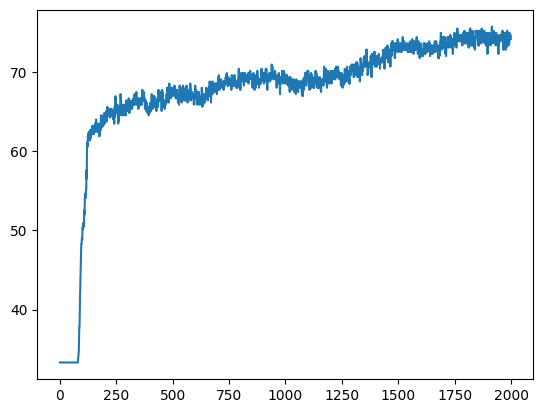

In [112]:
plt.plot(test_accs)


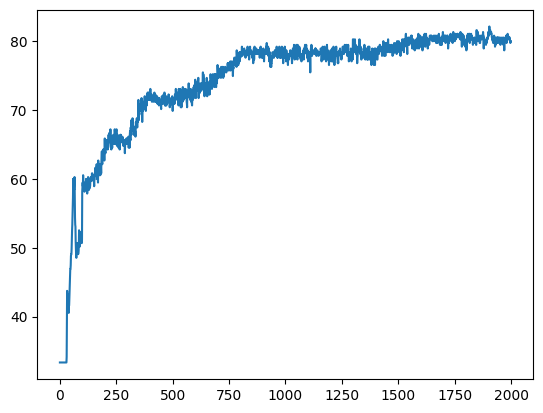

In [110]:
plt.plot(test_accs)


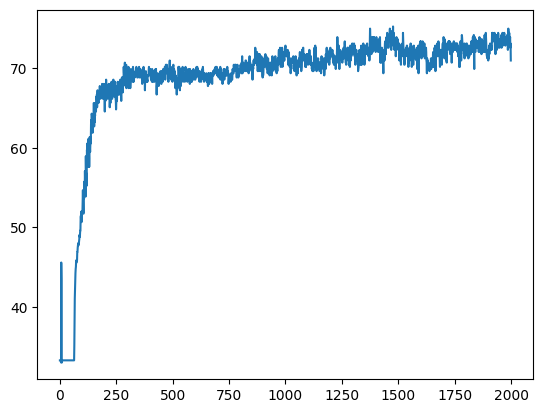

In [97]:
plt.plot(test_accs)


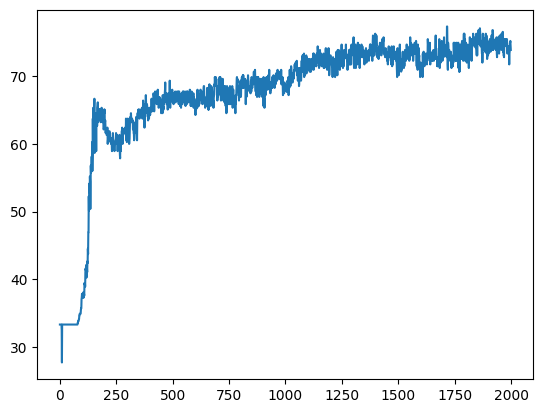

In [45]:
plt.plot(test_accs)


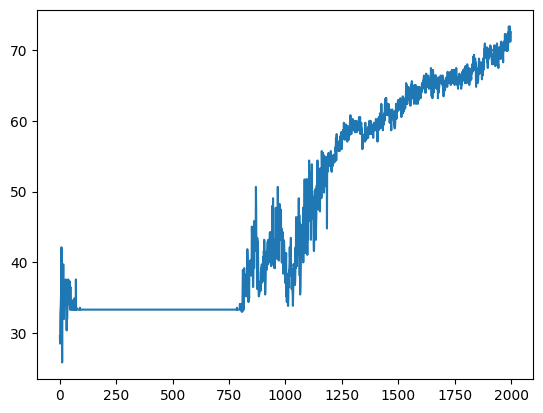

In [40]:
plt.plot(test_accs)

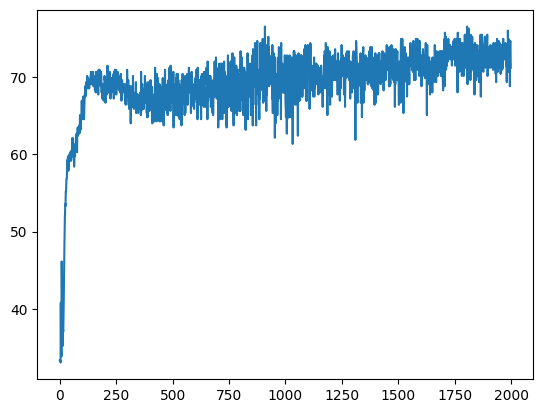

In [37]:
plt.plot(test_accs)